In [5]:
pip install matplotlib

  Using cached matplotlib-3.4.1-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!nvidia-smi

Wed May  5 00:40:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1B.0 Off |                    0 |
| N/A   28C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:1C.0 Off |                    0 |
| N/A   

In [6]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input
# import tf_slim as slim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random
%matplotlib inline
np.random.seed(2)

In [7]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [8]:
h = 224
w = 224
image_size = (h, w)

np_arr = lambda img: np.array(img.resize(image_size)).flatten() / 255.0

def prepare_image(image_path):
    return np_arr(convert_to_ela_image(image_path, 95))

In [9]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [10]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X.append(prepare_image(full_path))
                    Y.append(cls)
                except:
                    pass
                if len(Y) % 500 == 0:
                    print('Processing {} images'.format(len(Y)))

In [11]:
#place authentic
Au_path = '../synthetic/Au'
prepare_data(Au_path, 1)
random.shuffle(X)
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
Processing 7500 images
Processing 8000 images
8173 8173


In [12]:
#place tampered
Tp_path = '../synthetic/Tp'
prepare_data(Tp_path, 0)
print(len(X), len(Y))

Processing 8500 images
Processing 9000 images
Processing 9500 images
Processing 10000 images
Processing 10500 images
Processing 11000 images
Processing 11500 images
Processing 12000 images
12477 12477


In [13]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, h, w, 3)

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

X = X.reshape(-1,1,1,1)

In [34]:
input = Input(shape=(h, w, 3))
x = Conv2D(32, 3, padding='valid', activation='relu')(input)
x = Conv2D(32, 3, padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = BatchNormalization()(x)
# x = Dropout(0.25)(x)

x = Conv2D(32, 3, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, 3, padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = BatchNormalization()(x)
# x = Dropout(0.25)(x)

# x = Conv2D(64, 3, padding='valid', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, 3, padding='valid', activation='relu')(x)
# x = MaxPool2D(pool_size=2)(x)
# x = BatchNormalization()(x)

# x = Conv2D(256, 3, padding='valid', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(256, 3, padding='valid', activation='relu')(x)
# x = MaxPool2D(pool_size=2)(x)
# x = BatchNormalization()(x)

# x = Conv2D(512, 3, padding='valid', activation='relu')(x)
# x = BatchNormalization()(x)
# x = Conv2D(512, 3, padding='valid', activation='relu')(x)
# x = MaxPool2D(pool_size=2)(x)
# x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 108, 108, 32)      9248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 106, 106, 32)     

In [35]:
epochs = 50
batch_size = 32
init_lr = 1e-4
# optimizer = Adam(lr = init_lr)
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0,patience=3, verbose=0, mode='auto')

checkpoint_filepath = 'ela_synthetic/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [36]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/50
  2/312 [..............................] - ETA: 14s - loss: 0.6897 - accuracy: 0.6094WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0286s vs `on_train_batch_end` time: 0.0614s). Check your callbacks.


312/312 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.6994WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0061s vs `on_test_batch_end` time: 0.0124s). Check your callbacks.


312/312 [==============================] - 30s 95ms/step - loss: 0.5900 - accuracy: 0.6994 - val_loss: 0.5759 - val_accuracy: 0.7240
Epoch 2/50
312/312 [==============================] - 25s 81ms/step - loss: 0.5093 - accuracy: 0.7873 - val_loss: 0.5984 - val_accuracy: 0.6783
Epoch 3/50
312/312 [==============================] - 25s 81ms/step - loss: 0.4765 - accuracy: 0.8062 - val_loss: 0.6110 - val_accuracy: 0.6871
Epoch 4/50
312/312 [==============================] - 28s 90ms/step - loss: 0.4700 - accuracy: 0.8018 - val_loss: 0.4769 - val_accuracy: 0.8049
Epoch 5/50
312/312 [==============================] - 25s 82ms/step - loss: 0.4507 - accuracy: 0.8169 - val_loss: 0.4928 - val_accuracy: 0.7833
Epoch 6/50
312/312 [==============================] - 26s 82ms/step - loss: 0.4451 - accuracy: 0.8153 - val_loss: 0.4870 - val_accuracy: 0.7905
Epoch 7/50
312/312 [==============================] - 26s 83ms/step - loss: 0.4220 - accuracy: 0.8301 - val_loss: 0.5071 - val_accuracy: 0.7853


In [20]:
X_test_set = [] # SRM converted images
Y_test_set = [] # 0 for fake, 1 for real

In [21]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X_test_set.append(prepare_image(full_path))
                    Y_test_set.append(cls)
                except:
                    pass
                if len(Y_test_set) % 500 == 0:
                    print('Processing {} images'.format(len(Y_test_set)))

In [22]:
#place authentic
# synthetic_test/Au
Au_path = '../synthetic_test/Au'
prepare_data(Au_path, 1)
random.shuffle(X_test_set)
# X = X[:2100]
# Y = Y[:2100]
print(len(X_test_set), len(Y_test_set))

Processing 500 images
790 790


In [23]:
#place tampered
Tp_path = '../synthetic_test/Tp'
prepare_data(Tp_path, 0)
print(len(X_test_set), len(Y_test_set))

Processing 1000 images
1190 1190


In [24]:
X_test_set = np.array(X_test_set)
Y_test_set = to_categorical(Y_test_set, 2)
X_test_set = X_test_set.reshape(-1, h, w, 3)

x_test, x_test2, y_test, y_test2 = train_test_split(X_test_set, Y_test_set, test_size = 0.2, random_state=5)

# X_test = X_test.reshape(-1,1,1,1)

In [31]:
from sklearn.metrics import average_precision_score

predictions = model.predict(x_test)
average_precision = average_precision_score(y_test, predictions)

In [32]:
average_precision

0.8482920680193418

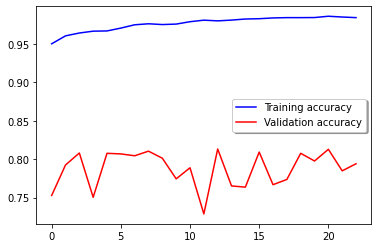

In [33]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = plt.legend(loc='best', shadow=True)
plt.savefig("acc.png", bbox_inches='tight', pad_inches=0)

In [44]:
from tensorflow.keras.models import load_model

model_1 = model.load_weights('srm_synthetic_7/checkpoint.hdf5')

In [45]:
predictions = model_1.predict(x_test)
average_precision = average_precision_score(y_test, predictions)

AttributeError: 'NoneType' object has no attribute 'predict'